# Exploration of airbnb and flat prices evolution in Madrid over last years

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
def nice_line_plot(y_min, y_max, y_labels, x_categories, x_cat_1, districts, color_legend, legend_y_pos, 
                   data, title, link_data_source, link_source_hight):
    # Example obtained from blog post: 
    # http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
    
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
    for i in range(len(color_legend)):    
        r, g, b = color_legend[i]    
        color_legend[i] = (r / 255., g / 255., b / 255.)
           
    plt.figure(figsize=(15, 13)) 
    
    # Remove the plot frame lines. They are unnecessary chartjunk.    
    ax = plt.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    
    # Ensure that the axis ticks only show up on the bottom and left of the plot.    
    # Ticks on the right and top of the plot are generally unnecessary chartjunk.    
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    
    # Limit the range of the plot to only where the data is.    
    # Avoid unnecessary whitespace.    
    plt.ylim(y_min, y_max)    
    plt.xlim(x_categories[0], x_categories[-1]) 
    
    # Make sure your axis ticks are large enough to be easily read.    
    # You don't want your viewers squinting to read your plot.    
    plt.yticks(y_labels, y_labels, fontsize=8)    
    plt.xticks(fontsize=8)
    
    # Provide tick lines across the plot to help your viewers trace along    
    # the axis ticks. Make sure that the lines are light and small so they    
    # don't obscure the primary data lines.    
    for y in y_labels:    
        plt.plot(x_categories, [y] * len(x_categories), "--", lw=0.5, color="black", alpha=0.3)
        
    # Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
    plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                    labelbottom="on", left="off", right="off", labelleft="on") 
  
    for rank, column in enumerate(districts):    
        # Plot each line separately with its own color, using the Tableau 20    
        # color set in order.    
        plt.plot(data.index.tolist(),    
                data[column].values,    
                lw=2.5, color=color_legend[rank])    
  
        plt.text(x_cat_1, legend_y_pos[rank], column, fontsize=10, color=color_legend[rank]) 

    plt.xlabel("Date")
    plt.title(title)      
    plt.text(x_categories[0], y_min-link_source_hight, "Data source: "+link_data_source+    
           "\nAuthor: Celsa Diaz", fontsize=8)    
    
    #plt.savefig(title+".png", bbox_inches="tight")

### 1. Airbnb evolution over time

In [3]:
airbnb = pd.read_csv('./data/airbnb_dataset.csv')
link_location_airbnb_data = "http://data.insideairbnb.com/spain/comunidad-de-madrid/madrid/2018-01-17/data/listings.csv.gz"

In [4]:
inhabitants_2015 = pd.read_csv('../district_census_madrid_analysis/complete_clean_census_madrid.csv')
ref_n_inhabitants = inhabitants_2015[(inhabitants_2015['Unnamed: 0'] == 'Total') & 
                         (inhabitants_2015['year'] == 2015)].loc[:,['district',
                         'total']].reset_index(drop=True).rename(columns={'total':'n_inhabitants'})

In [5]:
columns = ['date', 'district', 'n_hosts', 'n_posts', 'n_latlongs', 'n_total']
elements = []
for i, df in airbnb.groupby(['date','neighbourhood_group']):
    n_total = len(df)
    n_latlongs = len(df.drop_duplicates(subset=['latitude', 'longitude']))
    n_posts = len(df.name.unique())
    n_hosts = len(df.host_id.unique())
    date = i[0]
    district = i[1]
    elements.append([date, district, n_hosts, n_posts, n_latlongs, n_total])
airbnb_results = pd.DataFrame(elements, columns=columns)

In [6]:
# Normalize number of listings by the number of inhabitants
airbnb_results = airbnb_results.merge(ref_n_inhabitants, left_on='district', right_on='district')
airbnb_results['n_total_norm'] = airbnb_results['n_total']/airbnb_results['n_inhabitants']

In [7]:
airbnb_results['date'] = pd.to_datetime(airbnb_results.date).dt.date
airbnb_results['n_log_total'] = (np.log10(airbnb_results['n_total_norm'])).round(3)

In [8]:
airbnb_results.head()

,date,district,n_hosts,n_posts,n_latlongs,n_total,n_inhabitants,n_total_norm,n_log_total
0,2015-07-01,Arganzuela,341,424,430,430,131568,0.003268,-2.486
1,2015-09-01,Arganzuela,353,438,444,444,131568,0.003375,-2.472
2,2015-10-01,Arganzuela,334,404,410,410,131568,0.003116,-2.506
3,2017-01-01,Arganzuela,753,935,944,944,131568,0.007175,-2.144
4,2017-03-01,Arganzuela,616,769,775,775,131568,0.005890,-2.230


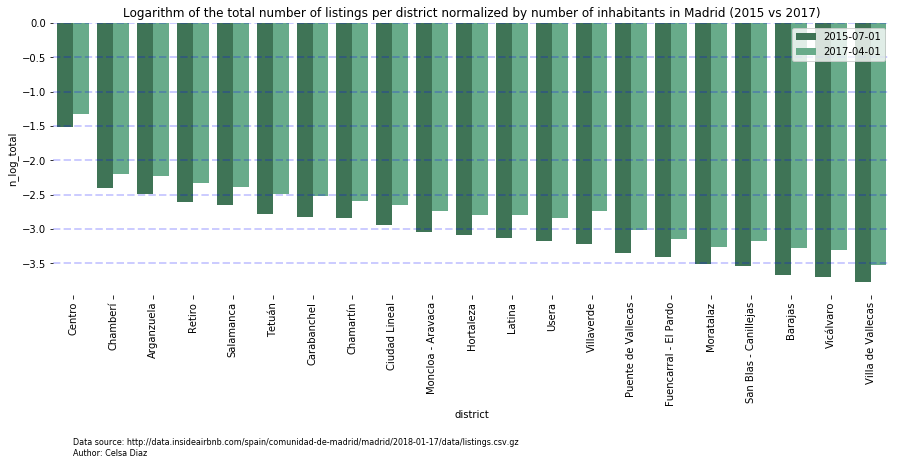

In [10]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='n_log_total',data=airbnb_results[airbnb_results['date'].isin([datetime.date(2015, 7, 1),
                                                                                          datetime.date(2017, 4, 1)])],
            hue='date', order=['Centro','Chamberí','Arganzuela','Retiro',
                                                       'Salamanca','Tetuán','Carabanchel','Chamartín',
                                                       'Ciudad Lineal','Moncloa - Aravaca','Hortaleza',
                                                       'Latina','Usera','Villaverde','Puente de Vallecas',
                                                       'Fuencarral - El Pardo','Moratalaz','San Blas - Canillejas',
                                                       'Barajas','Vicálvaro','Villa de Vallecas'],
           palette="BuGn_d")
ax.set_title("Logarithm of the total number of listings per district normalized by number of inhabitants in Madrid (2015 vs 2017)")
plt.text(0, -6.3, "Data source: "+link_location_airbnb_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
plt.legend(loc = 'upper right')
_ = plt.xticks(rotation='vertical')

In [11]:
data_kpi_n_total = airbnb_results.loc[:,['date','district','n_log_total']].pivot(index='date', 
                                                                     columns='district', 
                                                                     values='n_log_total')
districts = data_kpi_n_total.columns.tolist()
dates = data_kpi_n_total.index.unique().tolist()
y_min = airbnb_results['n_log_total'].min()
y_max = airbnb_results['n_log_total'].max()
y_interval = 0.5
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = datetime.date(2017, 5, 1)
legend_y_pos = [-2.2198770855974819, -3.2689562432479966, -2.5187785384737471, -1.3236292688365707, -2.5939790984325541, -2.1806050088350934, -2.649186721933138, -3.1355421333577291, -2.8359920788804737, -2.7921310124128791, -2.7035395463637183, -3.2247341942224031, -3.0091828293239753, -2.3354007790762101, -2.3809156404372822, -3.1702617153949575, -2.4826210420456607, -2.8773358680150149, -3.3102558619324882, -3.5213086740100867, -2.741901159670773]
link_source_hight = 0.2
title = "Total number of listings per district normalized by number of inhabitants in Madrid (2015-2017)"

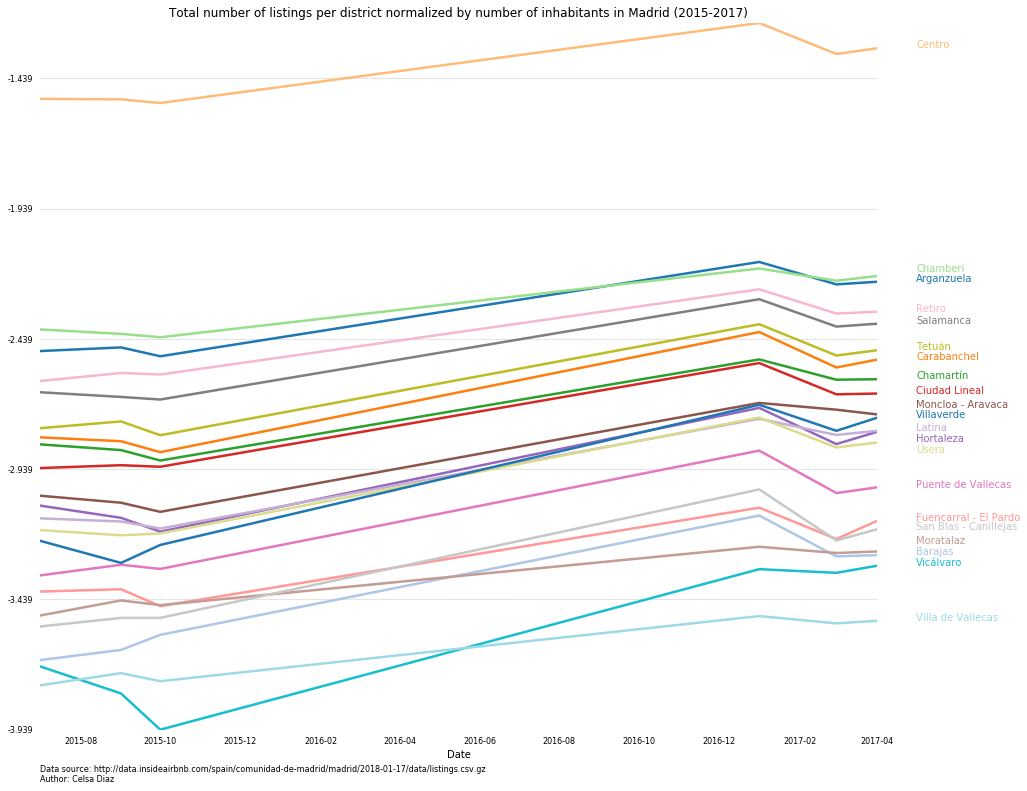

In [12]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               data_kpi_n_total, title, link_location_airbnb_data, link_source_hight)

###### To highlight:
* Notice that the plot is in logarithmic scale
* We see clearly that those districts with higher gentrification are the same with higher number of listings.

#### 1.1. Calculate ratios

In [13]:
def calculate_ratio_total_vs_hosts(data):
    return airbnb_results['n_total'] / airbnb_results['n_hosts']

def calculate_ratio_reference(data):
    ref_values = data.sort_values(by=['date']).groupby(['district']).first().reset_index().rename(columns={'n_total':'n_total_ref'})
    ref_values = ref_values.loc[:,['district','n_total_ref']]
    data_ = data.merge(ref_values, left_on='district', right_on='district')
    data_['ratio_reference'] = (data_['n_total'] / data_['n_total_ref']).round(3)
    return data_

In [14]:
airbnb_results['ratio_listints_hosts'] = calculate_ratio_total_vs_hosts(airbnb_results)
airbnb_results_ = calculate_ratio_reference(airbnb_results)

In [15]:
airbnb_results_.head()

,date,district,n_hosts,n_posts,n_latlongs,n_total,n_inhabitants,n_total_norm,n_log_total,ratio_listints_hosts,n_total_ref,ratio_reference
0,2015-07-01,Arganzuela,341,424,430,430,131568,0.003268,-2.486,1.260997,430,1.000
1,2015-09-01,Arganzuela,353,438,444,444,131568,0.003375,-2.472,1.257790,430,1.033
2,2015-10-01,Arganzuela,334,404,410,410,131568,0.003116,-2.506,1.227545,430,0.953
3,2017-01-01,Arganzuela,753,935,944,944,131568,0.007175,-2.144,1.253652,430,2.195
4,2017-03-01,Arganzuela,616,769,775,775,131568,0.005890,-2.230,1.258117,430,1.802


###### Evolution of ratio number of listings/number of hosts

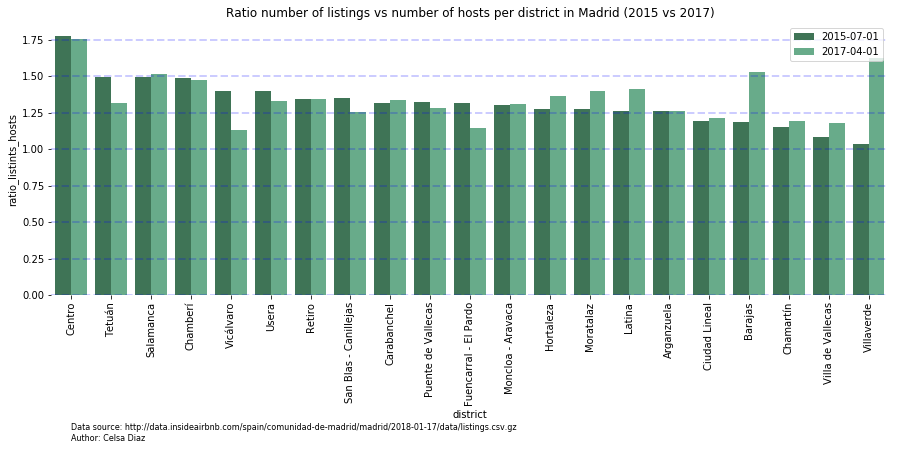

In [16]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='ratio_listints_hosts',
            data=airbnb_results_[airbnb_results_['date'].isin([datetime.date(2015, 7, 1),
                                                               datetime.date(2017, 4, 1)])],
            hue='date', order=['Centro','Tetuán','Salamanca','Chamberí','Vicálvaro','Usera','Retiro',
                               'San Blas - Canillejas','Carabanchel','Puente de Vallecas',
                               'Fuencarral - El Pardo','Moncloa - Aravaca','Hortaleza','Moratalaz',
                               'Latina','Arganzuela','Ciudad Lineal','Barajas','Chamartín',
                               'Villa de Vallecas','Villaverde'],
           palette="BuGn_d")
ax.set_title("Ratio number of listings vs number of hosts per district in Madrid (2015 vs 2017)")
plt.text(0, -1, "Data source: "+link_location_airbnb_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
plt.legend(loc = 'upper right')
_ = plt.xticks(rotation='vertical')

In [17]:
data_kpi_n_listings_n_hosts = airbnb_results_.loc[:,['date','district','ratio_listints_hosts']].pivot(index='date', 
                                                                     columns='district', 
                                                                     values='ratio_listints_hosts')
districts = data_kpi_n_listings_n_hosts.columns.tolist()
dates = data_kpi_n_listings_n_hosts.index.unique().tolist()
y_min = airbnb_results_['ratio_listints_hosts'].min()
y_max = airbnb_results_['ratio_listints_hosts'].max()
y_interval = 0.1
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = datetime.date(2017, 5, 1)
legend_y_pos = [1.2527388535031847, 1.548301886792453, 1.3608239700374531, 1.7528438469493277, 1.1914191419141915, 1.476923076923077, 1.2117647058823529, 1.1486486486486487, 1.3776470588235294, 1.424179104477612, 1.2969533527696795, 1.4062264150943395, 1.2732369942196531, 1.3425076452599389, 1.5171821305841924, 1.2353191489361701, 1.3131818181818182, 1.3302752293577982, 1.1233333333333333, 1.1694871794871795, 1.6274509803921569]
link_source_hight = 0.07
title = "Ratio number of listings vs number of hosts per district in Madrid (2015-2017)"

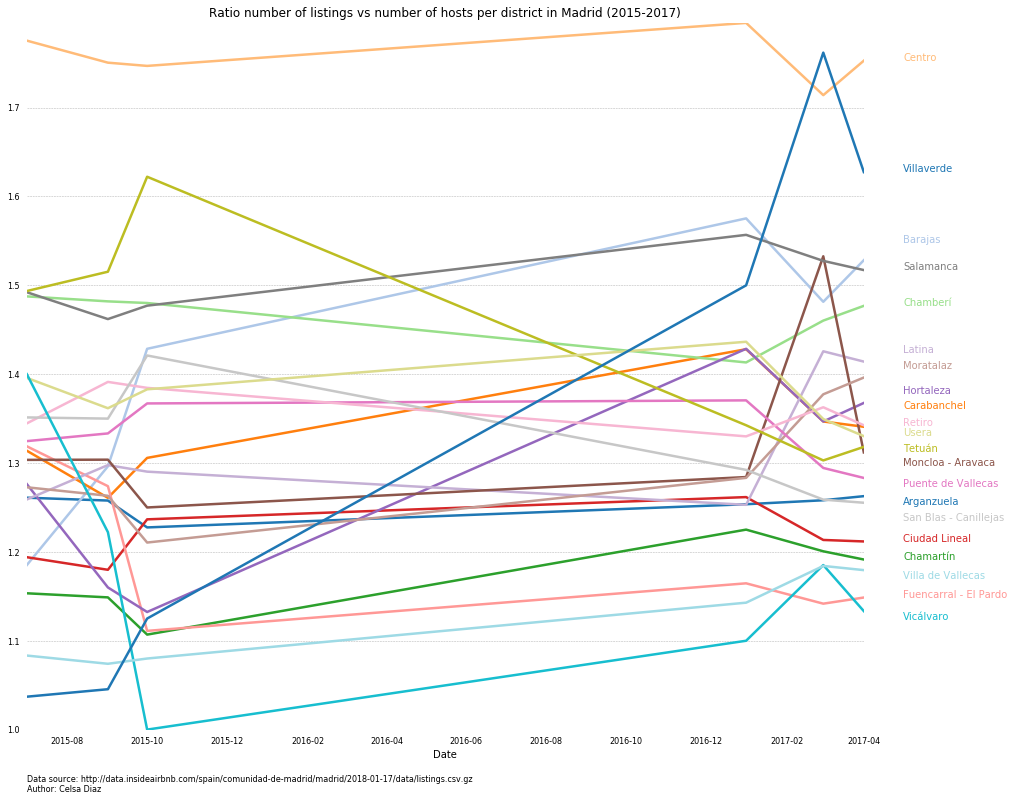

In [18]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               data_kpi_n_listings_n_hosts, title, link_location_airbnb_data, link_source_hight)

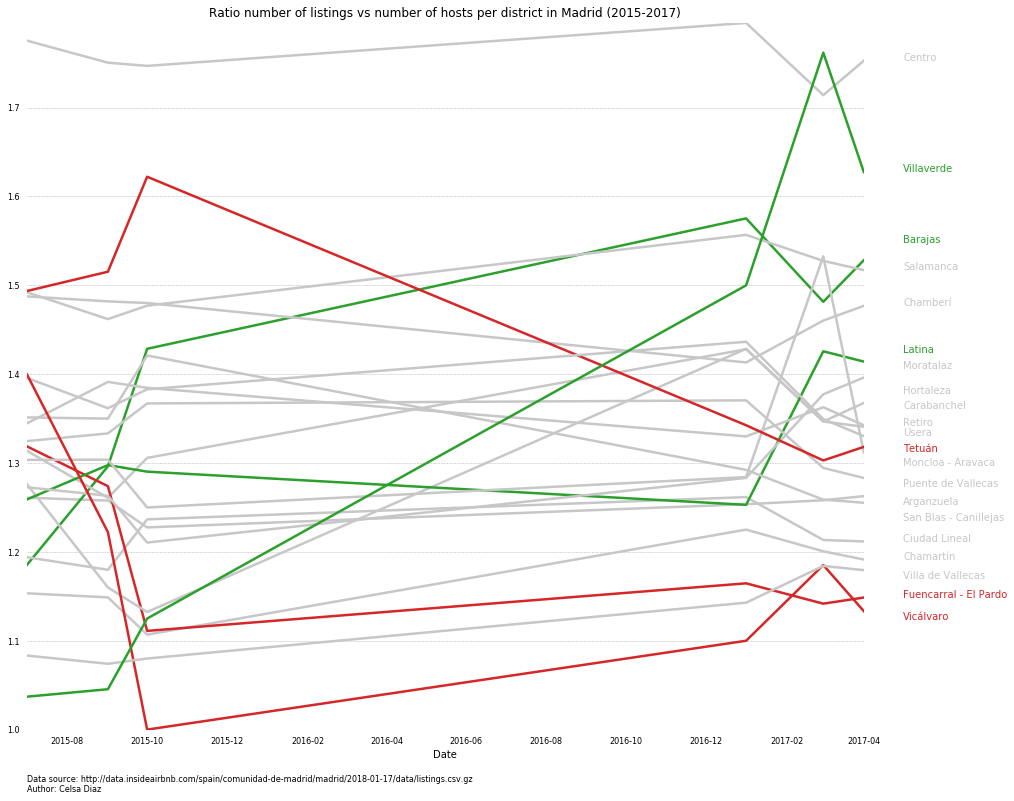

In [19]:
color_legend = [(199, 199, 199), (44, 160, 44), (199, 199, 199), (199, 199, 199),    
             (199, 199, 199), (199, 199, 199), (199, 199, 199), (214, 39, 40),    
             (199, 199, 199), (44, 160, 44), (199, 199, 199), (199, 199, 199),    
             (199, 199, 199), (199, 199, 199), (199, 199, 199), (199, 199, 199),    
             (214, 39, 40), (199, 199, 199), (214, 39, 40), (199, 199, 199),
             (44, 160, 44)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               data_kpi_n_listings_n_hosts, title, link_location_airbnb_data, link_source_hight)

##### To highlight:
* We should consider that there is a gap in the data for 2016.
* This plots show the districts where the same host is renting more than one room which is, in principle, against the idea of AirBnb
* Villaverde and Barajas are not districts considered as gentrified. However, Barajas is closed to the airport and Villaverde is one of the cheapest districts of Madrid. It seems that these features are the perfect incubators for Airbnb hunters.
* On the other hand, districts such as Fuencarral-El Pardo or Vicalvaro that are at the same distance to the center than the previous ones but the prices are higher. This may unmotivate Airbnb hunters.
* Regarding the trends in the center, we see more clearly the effect of gentrification. La Latina, a trend district has increased the ratio listings/hosts whereas Tetuan, a district with a higher average age of citizens, seems to be less attractive for Airbnb hunters.

###### Evolution of ratio number of listings/number of listings in 2015

In [20]:
data_kpi_ratio_n_listings = airbnb_results_.loc[:,['date','district','ratio_reference']].pivot(index='date', 
                                                                     columns='district', 
                                                                     values='ratio_reference')
districts = data_kpi_ratio_n_listings.columns.tolist()
dates = data_kpi_ratio_n_listings.index.unique().tolist()
y_min = airbnb_results_['ratio_reference'].min()
y_max = airbnb_results_['ratio_reference'].max()
y_interval = 0.5
y_labels = np.arange(y_min, y_max, y_interval)
legend_y_pos = [1.7720000000000001, 2.5310000000000001, 1.9640000000000001, 1.5130999999999999, 1.694, 1.545, 1.921, 1.8090000000000001, 1.8779999999999999, 2.1659999999999999, 2.0550000000000002, 1.628, 2.1960000000000002, 1.845, 1.7350000000000001, 2.3599999999999999, 2.0050000000000001, 2.1240000000000001, 2.4289999999999998, 1.6600999999999999, 2.964]
link_source_hight = 0.3
title = "Evolution of the number of listings per district in Madrid (2015-2017)"

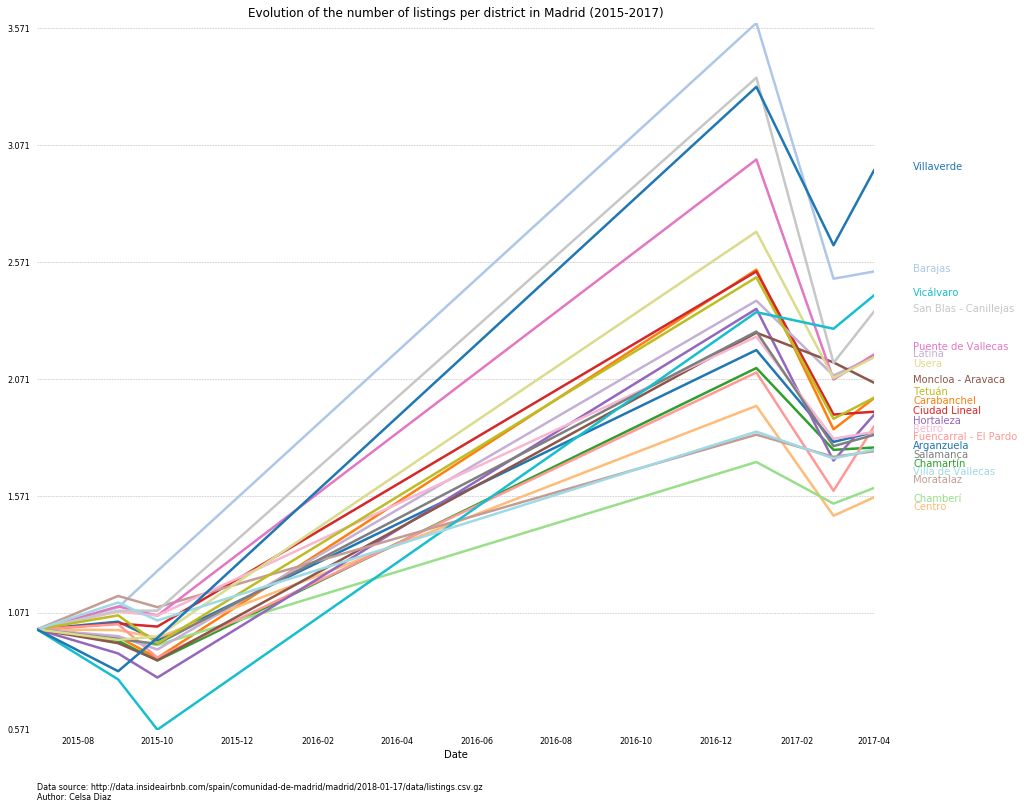

In [21]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               data_kpi_ratio_n_listings, title, link_location_airbnb_data, link_source_hight)

##### To highlight:
* We should consider that there is a gap in the data for 2016 and that the months where data is provided are different (notice that listings on summer may be different than on February).
* The number of listings offered by Airbnb has increased in almost 250% in some cases since 2015.
* Surprisingly, traditionally worker districts seem to have a stronger increase in the number of listings in comparison to those traditionally gentrified. Most likely, Airbnb took more time to be spread in these districts.
* In more expensive districts that did not suffer from gentrification, the increment on the number of listings is much lower (50% in the case of Chamartin).

### 2. Rental and Sale prices per m2 evolution over time per district

In [46]:
sale = pd.read_csv('./data/sale_price_m2_districts.csv')
rent = pd.read_csv('./data/rent_price_m2_districts.csv')
link_location_price_data = "https://www.idealista.com/informes-precio-vivienda"

# drop vicalvaro since rental data is missing for 2016 and 2017
sale = sale[sale['district'] != 'vicálvaro']
rent = rent[rent['district'] != 'vicálvaro']

sale['price_m2'] = sale['price_m2'].str.split(' ').apply(lambda x: ''.join(x)).str.split('.').apply(lambda x: ''.join(x)).astype(int)
rent['price_m2'] = rent['price_m2'].str.split(' ').apply(lambda x: ''.join(x).replace(',','.')).astype(float)

In [47]:
district_dict = {'arganzuela': 'Arganzuela',
 'barajas': 'Barajas',
 'carabanchel': 'Carabanchel',
 'centro': 'Centro',
 'chamartín': 'Chamartín',
 'chamberí': 'Chamberí',
 'ciudad lineal': 'Ciudad Lineal',
 'fuencarral': 'Fuencarral - El Pardo',
 'hortaleza': 'Hortaleza',
 'latina': 'Latina',
 'moncloa': 'Moncloa - Aravaca',
 'moratalaz': 'Moratalaz',
 'puente de vallecas': 'Puente de Vallecas',
 'retiro': 'Retiro',
 'salamanca': 'Salamanca',
 'san blas': 'San Blas - Canillejas',
 'tetuán': 'Tetuán',
 'usera': 'Usera',
 'villa de vallecas': 'Villa de Vallecas',
 'villaverde': 'Villaverde',
 'madrid': 'madrid'}

#sale['district'] = sale['district'].apply(lambda x: district_dict[x])
#rent['district'] = rent['district'].apply(lambda x: district_dict[x])

#### 2.1. Calculate ratios

In [48]:
def calculate_ratio_reference_idealista(data):
    ref_values = data.sort_values(by=['year']).groupby(['district']).first().reset_index().rename(columns={'price_m2':'price_m2_ref'})
    ref_values = ref_values.loc[:,['district','price_m2_ref']]
    data_ = data.merge(ref_values, left_on='district', right_on='district')
    data_['ratio_reference'] = data_['price_m2'] / data_['price_m2_ref']
    return data_

###### Evolution of sales prices per m2 by district since 2007

In [49]:
sale_ = calculate_ratio_reference_idealista(sale)

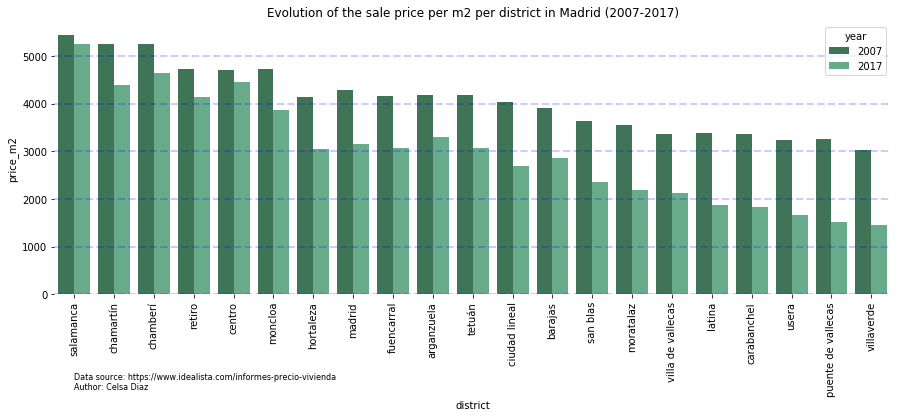

In [25]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='price_m2',data=sale_[sale_['year'].isin([2007,2017])],hue='year',
            order=['salamanca','chamartín','chamberí','retiro',
                                                       'centro','moncloa','hortaleza','madrid',
                                                       'fuencarral','arganzuela','tetuán','ciudad lineal',
                                                       'barajas','san blas','moratalaz',
                                                       'villa de vallecas','latina','carabanchel',
                                                       'usera','puente de vallecas','villaverde'],
           palette="BuGn_d")
ax.set_title("Evolution of the sale price per m2 per district in Madrid (2007-2017)")
plt.text(0, -2000, "Data source: "+link_location_price_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
_ = plt.xticks(rotation='vertical')

In [30]:
sale_kpi = sale_.loc[:,['year','district','ratio_reference']].pivot(index='year', 
                                                                     columns='district', 
                                                                     values='ratio_reference').drop(['madrid'],axis=1)
districts = sale_kpi.columns.tolist()
dates = sale_kpi.index.unique().tolist()
y_min = sale_['ratio_reference'].min()
y_max = sale_['ratio_reference'].max()
y_interval = 0.11
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = 2017
legend_y_pos = [0.78685782556750294, 0.734375, 0.54188948306595364, 0.94607218683651806, 0.83441187666539784, 0.88419047619047619, 0.66799007444168734, 0.73690533397405089, 0.73571256329877022, 0.5557527358769595, 0.81845049609457465, 0.61748173130972461, 0.46693325130729008, 0.87595258255715491, 0.96632934682612692, 0.65205403915081339, 0.73306297709923662, 0.51347166305357694, 0.6314379279547484, 0.47612775765558119]
link_source_hight = 0.1
title = "Evolution of the sale price per m2 with respect to 2007 prices per district in Madrid (2007-2017)"

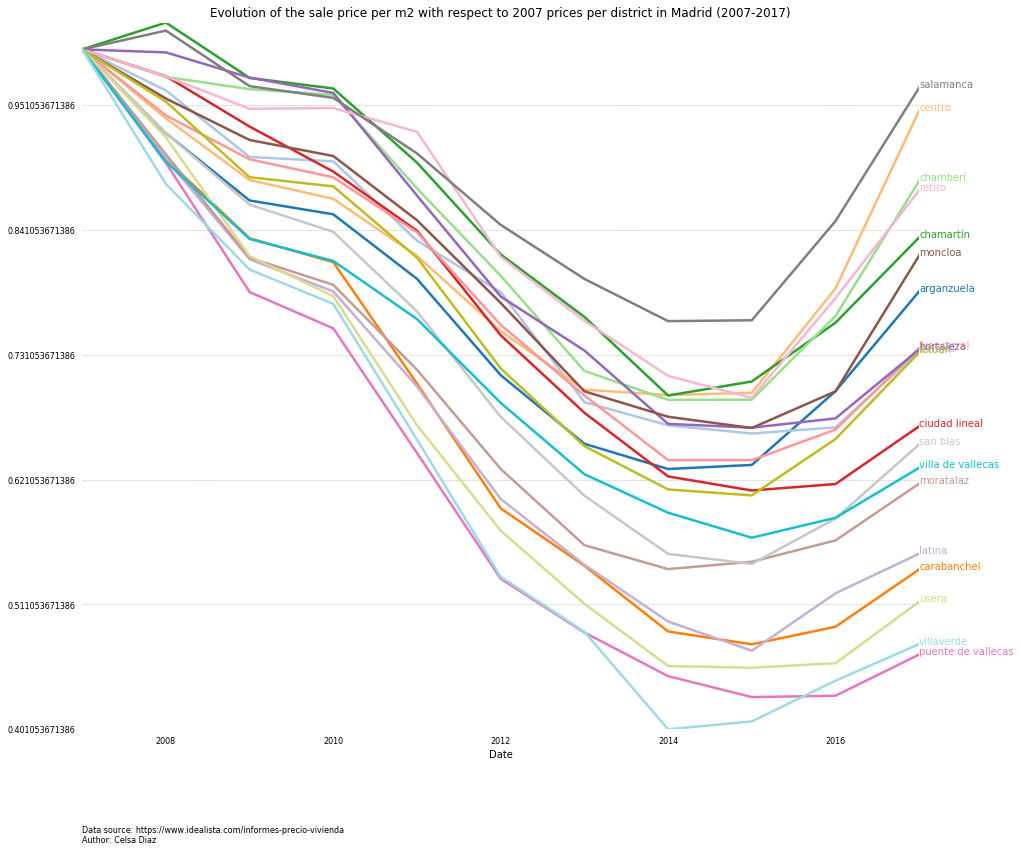

In [31]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               sale_kpi, title, link_location_price_data, link_source_hight)

###### Evolution of rental prices per m2 by district since 2007

In [50]:
rent_ = calculate_ratio_reference_idealista(rent)

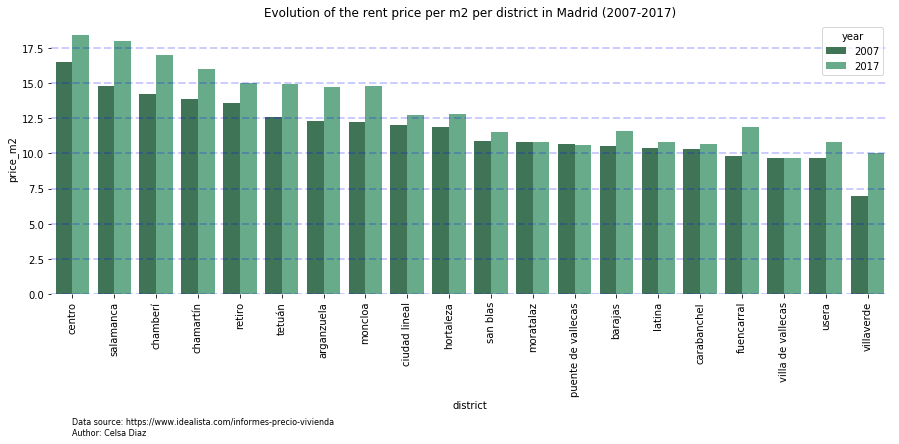

In [33]:
plt.figure(figsize=(15, 5)) 
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
    
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()
ax.grid(color='b', linestyle='--', linewidth=2, alpha=0.2)
sns.barplot(x='district',y='price_m2',data=rent_[rent_['year'].isin([2007,2017])],hue='year',
            order=['centro','salamanca','chamberí','chamartín','retiro','tetuán','arganzuela',
                                                       'moncloa','ciudad lineal','hortaleza',
                                                       'san blas','moratalaz','puente de vallecas',
                                                       'barajas','latina','carabanchel','fuencarral',
                                                       'villa de vallecas',
                                                       'usera','villaverde'],
           palette="BuGn_d")
ax.set_title("Evolution of the rent price per m2 per district in Madrid (2007-2017)")
plt.text(0, -10, "Data source: "+link_location_price_data+    
           "\nAuthor: Celsa Diaz", fontsize=8)
_ = plt.xticks(rotation='vertical')

In [36]:
rent_kpi = rent_.loc[:,['year','district','ratio_reference']].pivot(index='year', 
                                                                     columns='district', 
                                                                     values='ratio_reference').drop(['madrid'],axis=1)
districts = rent_kpi.columns.tolist()
dates = rent_kpi.index.unique().tolist()
y_min = rent_['ratio_reference'].min()
y_max = rent_['ratio_reference'].max()
y_interval = 0.1
y_labels = np.arange(y_min, y_max, y_interval)
x_cat_1 = 2017
legend_y_pos = [1.1951219512195121, 1.1047619047619048, 1.0388349514563104, 1.115151515151515, 1.1510791366906474, 1.1971830985915493, 1.0583333333333333, 1.2142857142857142, 1.0756302521008403, 1.0384615384615385, 1.2131147540983609, 1.0, 0.99065420560747663, 1.1029411764705883, 1.2162162162162162, 1.0550458715596329, 1.1825396825396826, 1.1134020618556704, 1.0, 1.4285714285714286]
link_source_hight = 0.1
title = "Evolution of the rent price per m2 with respect to 2007 prices per district in Madrid (2007-2017)"

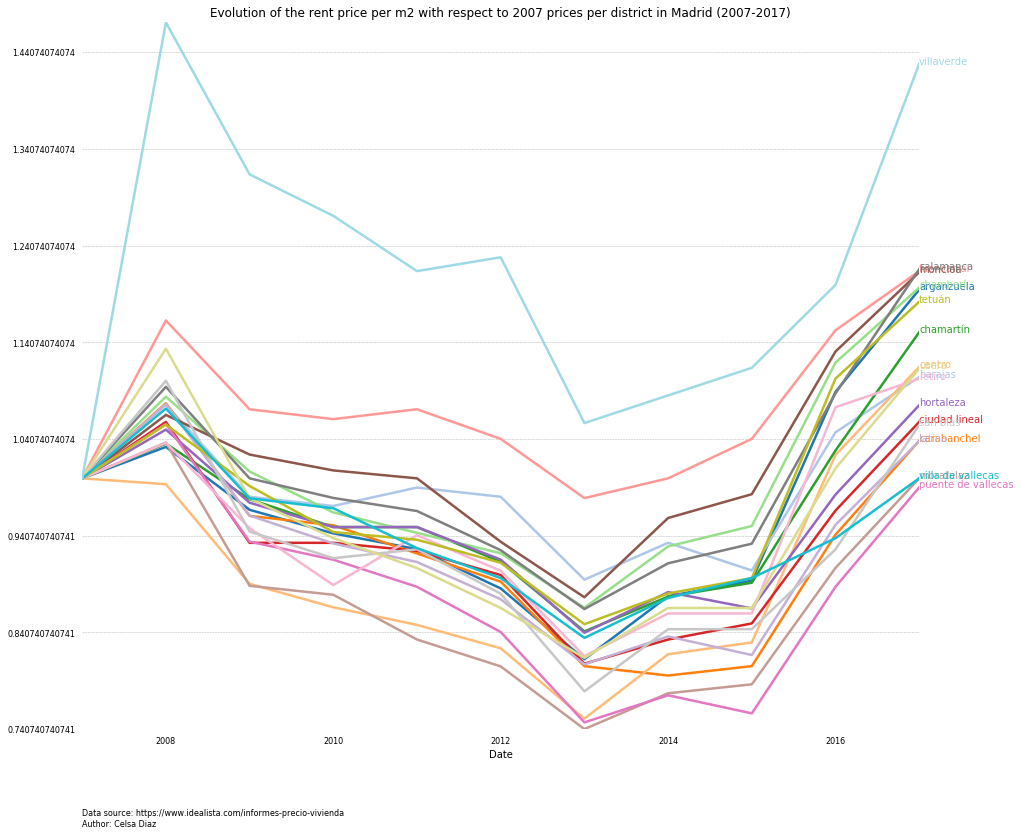

In [37]:
color_legend = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229),
             (31, 119, 180)]
nice_line_plot(y_min, y_max, y_labels, dates, x_cat_1, districts, color_legend, legend_y_pos,
               rent_kpi, title, link_location_price_data, link_source_hight)

In [51]:
rent_.to_csv('./data/rent_price_m2_districts_ratio.csv', index=False, encoding='utf-8')
sale_.to_csv('./data/sale_price_m2_districts_ratio.csv', index=False, encoding='utf-8')

###### Conclusions:
* There was a clear buble generated by having the lowest price of flats in Villaverde (a traditionally worker district) at 2014. Likely, this fenomena increased the number of sales and created a flow of poorer citizens to the district looking for afordable flats.
* Villaverde is the district with highest rate of listings per host with Centro. This is specially surprising since it is not one of the gentrified districts of Madrid. I suggest that it became the perfect place for speculation in crisis time where many families from low and middle class needed to find cheeper alternatives. Airbnb, despite of the original idea, became a great solution for survival in this district seems like.
* The price of m2 did not recover from the crisis yet, the main dicrease was in worker districts. These districts were more affected by the increase of unemployment and the fact is that many families had to sell their flats quickly much cheaper than the bought them. The need to sell may have had an effect on the decrease of the prices.
* On the other hand, the economical crisis generated a buble in the rental business, mainly in one of the humblest districts, Villaverde and the traditionally gentrified areas.
* Regarding the acceptance of Airbnb, we can see from the evolution of the number of listings over these years that gentrified districts quickly started to used whereas other districts in the suburbs took longer and only those with more market interest develop stronger. Two examples are Villaverde and Barajas, the district closed to the airport.